In [1]:
from scipy import linalg
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def compact_SVD(A, tol):
    """Implements the compact SVD algorithm of a matrixx A
    """
    
    eig_vals, V = linalg.eig(A.conj().T @ A)
    sigmas = np.sqrt(eig_vals)
    argsort = np.argsort(sigmas)[::-1]
    sigmas = sigmas[argsort]
    V = V[:, argsort]
    r = len(sigmas[sigmas > tol])
    sigmas_1 = sigmas[:r]
    V_1 = V[:, :r]
    U_1 = A @ V_1 / sigmas_1
    
    return np.real(U_1), sigmas_1, np.real(V_1.conj().T)

In [3]:
# Test

A = np.random.random((5, 4))
U_1, sigmas_1, V_1H = compact_SVD(A, 1e-8)

print("U_1 is orthonormal: ", np.allclose(U_1.conj().T @ U_1, 
                                          np.identity(np.shape(U_1)[1])))
print("V1 is orthonormal: ", np.allclose(V_1H @ V_1H.conj().T, 
                                         np.identity(np.shape(V_1H)[1])))
S = np.diag(sigmas_1)
print("U_1SV_1H = A: ", np.allclose(U_1 @ S @ V_1H, A))
U, s, V_h = linalg.svd(A, full_matrices=False)
print("V_1H near Vh: ", np.allclose(np.abs(V_1H), np.abs(V_h)))
print("U_1 near U: ", np.allclose(np.abs(U_1), np.abs(U)))

U_1 is orthonormal:  True
V1 is orthonormal:  True
U_1SV_1H = A:  True
V_1H near Vh:  True
U_1 near U:  True


**Problem 2**

In [4]:
def SVDplot(A):
    """Computes and plots the SVD for a matrix A
    """
    
    π = np.linspace(0, 2 * np.pi, 200)
    x = np.cos(π)
    y = np.sin(π)
    S = np.vstack((x.T, y.T))
    E = np.array([[1, 0, 0], [0, 0, 1]])
    U, s, VH = linalg.svd(A)
    Σ = np.diag(s)
    VHS = VH @ S
    VHE = VH @ E
    ΣVHS = Σ @ VHS
    ΣVHE = Σ @ VHE
    UΣVHS = U @ ΣVHS
    UΣVHE = U @ ΣVHE
    X = [S, VHS, ΣVHS, UΣVHS]
    Y = [E, VHE, ΣVHE, UΣVHE]
    titles = ['$S$', '$V^HS$', '$ΣV^HS$', '$UΣV^HS$']
    
    fig, axs = plt.subplots(2, 2, figsize = (10, 10))
    for i in range(4):
        axs.ravel()[i].plot(X[i][0,:], X[i][1,:])
        axs.ravel()[i].plot(Y[i][0,:], Y[i][1,:])
        axs.ravel()[i].axis('equal')
        axs.ravel()[i].set_title(titles[i])

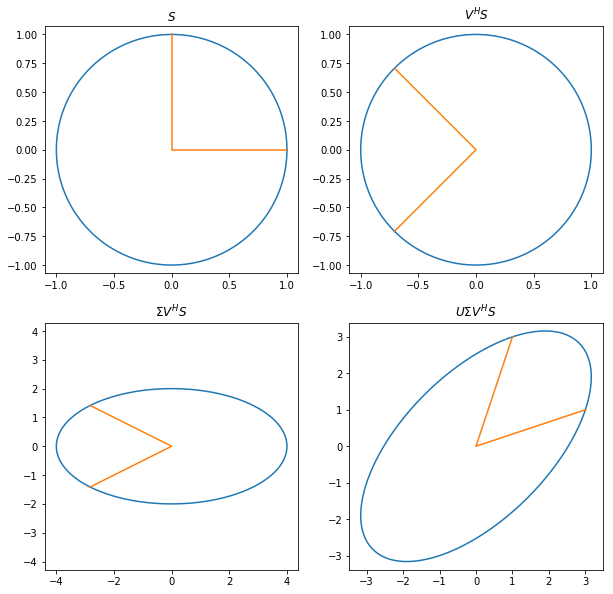

In [5]:
A = np.array([[3, 1], [1, 3]])
SVDplot(A)

**Problem 3**

In [6]:
def approx_rank(A, s):
    """Calculates the best rank approximation
    """
    
    U, S, V_h = linalg.svd(A, full_matrices=False)
    r = np.count_nonzero(S)
    if s > r:
        raise ValueError('s > rank(A)')
    
    truncU = U[:, :s]
    truncV_h = V_h[:s, :]
    truncΣ = np.diag(S)[:s, :s]
    
    A_s = truncU @ truncΣ @ truncV_h
    saved = s + truncU.size + truncV_h.size
    
    return A_s, saved

In [7]:
# Test

A = np.random.random((6, 6))
A_s, number = approx_rank(A, 3)
print("Rank: ", np.linalg.matrix_rank(A_s))
print("Number of entries: ", number)

Rank:  3
Number of entries:  39


**Problem 4**

In [8]:
def p4(A, ɛ):
    """Similar to the function defined in Problem 3, but we also will check 
    that ||A - A_s|| < ɛ
    """
    
    U, S, V_h = linalg.svd(A)
    Sɛ = S[S > ɛ]
    if ɛ < S.min():
        raise ValueError('Increase ɛ')
    s = len(Sɛ)
    
    truncU = U[:, :s]
    truncV_h = V_h[:s, :]
    truncS = S[:s]
    
    A_s = truncU @ np.diag(truncS) @ truncV_h
    saved = s + truncU.size + truncV_h.size
    
    error = linalg.norm(A - A_s, 2)
    Step = S[s]
    
    return A_s, saved, error, Step

In [9]:
# Test

for i in range(5):
    A = np.random.random((10, 10))
    A_s, number, error, Step = p4(A, 1)
    print("Error: ", round(error, 3))
    print("Singular value: ", round(Step, 3), "\n")

Error:  0.95
Singular value:  0.95 

Error:  0.775
Singular value:  0.775 

Error:  0.836
Singular value:  0.836 

Error:  0.996
Singular value:  0.996 

Error:  0.992
Singular value:  0.992 



**Problem 5**

In [10]:
def image(name, s):
    """Image compression
    """
    
    image = plt.imread(name) / 255.
    grayscale = len(image.shape) < 3
    if grayscale:
        cpr_image, j = approx_rank(image, s)
        images = [image, cpr_image]
    else:
        R = image[:, :, 0]
        cpr_R, r = approx_rank(R, s)
        B = image[:, :, 1]
        cpr_B, b = approx_rank(B, s)
        G = image[:, :, 2]
        cpr_G, g = approx_rank(G, s)
        cpr_image = np.dstack((cpr_R, cpr_B, cpr_G))
        cpr_image[cpr_image < 0] = 0
        cpr_image[cpr_image > 1] = 1
        images = [image, cpr_image]
        
    fig, axs = plt.subplots(1, 2, figsize = (8, 8))
    for i in range(2):
        axs.ravel()[i].imshow(images[i], cmap = "gray")
        axs.ravel()[i].axis("off")

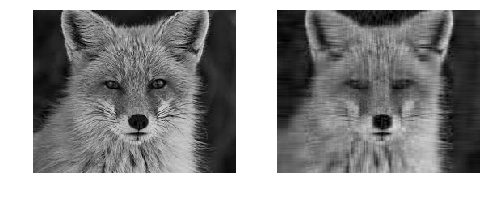

In [11]:
# Test 2

image("fox.jpg", 15) # Get it, because Daniel Fox...

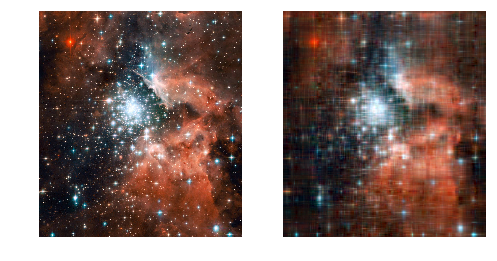

In [12]:
# Test 1

image("hubble.jpg", 15)